## インポートとモデル準備

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

MODEL_NAME = "prosusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
labels = ['negative', 'neutral', 'positive']

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


## ニュースcsvの読み込み

In [20]:
ticker = "BLK"
csv_path = f"../data/{ticker}_news_finnhub_20250518.csv"

df = pd.read_csv(csv_path)

# 感情分析対象のテキスト（headline + summary)
texts = df['headline'].fillna('') + '. ' + df['summary'].fillna('')

## 感情分析関数の定義

In [21]:
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
    return labels[pred]

## 分析実行

In [22]:
df['sentiment_finbert'] = texts.apply(get_sentiment)

# 数値スコアに変換(positive=1, neutral=0, negative=-1)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['sentiment_finbert'].map(sentiment_map)

output_path = f"../data/{ticker}_news_with_sentiment.csv"
df.to_csv(output_path, index=False)

print(f"analysis completed {output_path}")

analysis completed ../data/BLK_news_with_sentiment.csv


## FinBERT感情と株価の相関分析

In [23]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# 銘柄
ticker = "BLK"

# 過去30日の株価取得
end_date = datetime.today()
start_date = end_date - timedelta(days=30)
stock_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

# 株価データ
stock_df = stock_data[['Close']]
stock_df = stock_df.reset_index()
stock_df.columns = ['Date', 'Close']
stock_df['Date'] = stock_df['Date'].dt.strftime('%Y-%m-%d')

# 感情データ読み込み
sentiment_df = pd.read_csv(f"../data/{ticker}_news_with_sentiment.csv")
sentiment_df['date'] = pd.to_datetime(sentiment_df['datetime']).dt.strftime('%Y-%m-%d')
daily_sentiment = sentiment_df.groupby('date')['sentiment_score'].mean().reset_index()
daily_sentiment.rename(columns={'date': 'Date', 'sentiment_score': 'SentimentScore'}, inplace=True)

# merge
merged_df = pd.merge(stock_df, daily_sentiment, on='Date', how='inner')

[*********************100%***********************]  1 of 1 completed


In [24]:
print(merged_df.head())
correlation = merged_df[['Close', 'SentimentScore']].corr().iloc[0, 1]
print(f"相関係数: {correlation:.4f}")

         Date       Close  SentimentScore
0  2025-04-21  854.000000        0.600000
1  2025-04-22  887.219971        0.400000
2  2025-04-23  892.539978        0.500000
3  2025-04-24  916.260010        0.000000
4  2025-04-25  907.690002       -0.142857
相関係数: -0.2894


## 可視化

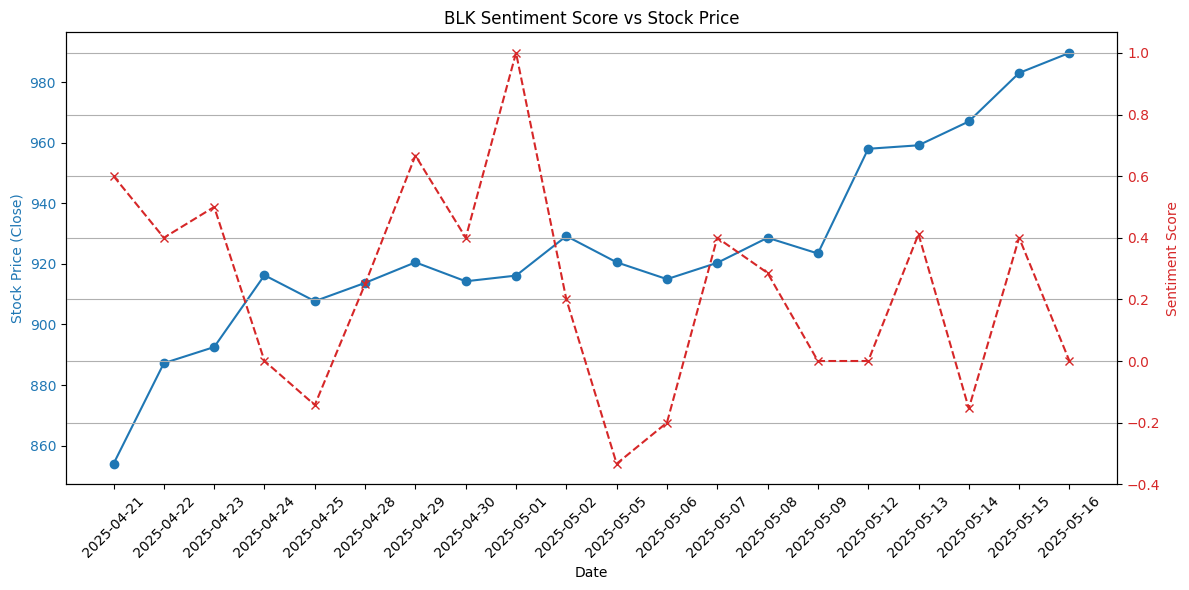

In [25]:
# 折れ線グラフ

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左Y軸：株価
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price (Close)', color=color)
ax1.plot(merged_df['Date'], merged_df['Close'], color=color, marker='o', label='Stock Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# 右Y軸：感情スコア
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(merged_df['Date'], merged_df['SentimentScore'], color=color, marker='x', linestyle='--', label='Sentiment Score')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'{ticker} Sentiment Score vs Stock Price')
fig.tight_layout()
plt.grid(True)
plt.show()

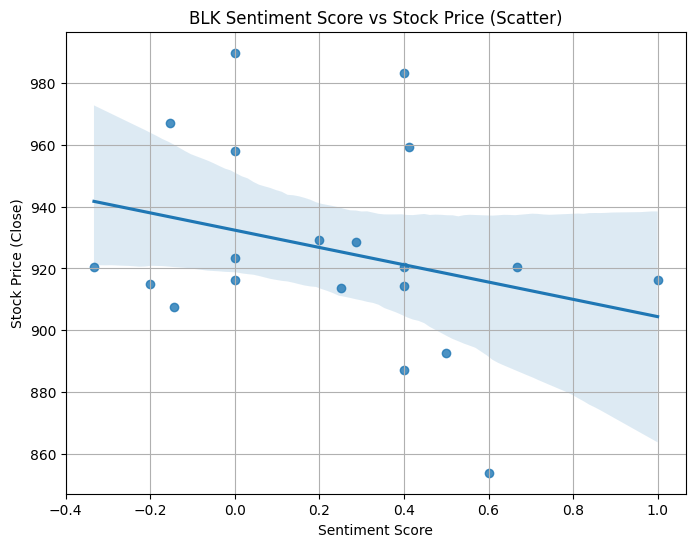

In [26]:
# 感情スコアvs株価の散布図
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(x='SentimentScore', y='Close', data=merged_df)
plt.title(f'{ticker} Sentiment Score vs Stock Price (Scatter)')
plt.xlabel('Sentiment Score')
plt.ylabel('Stock Price (Close)')
plt.grid(True)
plt.show()